In [1]:
# %% [markdown]
# # Federated Learning: Evaluate Global Model
# 
# This notebook is designed to:
# - Load the saved encoder, scaler, and global model parameters.
# - Preprocess the global dataset using the same logic as clients.
# - Evaluate the global model on the global dataset.
# 
# ## Sections:
# 1. Preprocessing
# 2. Model Reconstruction and Evaluation

# %% [markdown]
# ## 1. Preprocessing
# This section loads the encoder and scaler used by clients and applies them to preprocess the global dataset.

# %% [code]
# Import necessary libraries
import pandas as pd
import numpy as np
from joblib import load
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Import necessary libraries for evaluation
from io import BytesIO
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt 

In [2]:
# Load the global dataset
data_path = "../../../data/Telco-Customer-Churn.csv"
df = pd.read_csv(data_path)

# Drop the customerID column as it is not useful for modeling.
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric
if 'TotalCharges' in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Load the encoder and scaler
encoder_path = "../../client/metadata/encoder.pkl"
scaler_path = "../../client/metadata/scaler.pkl"

encoder = load(encoder_path)
print("Encoder loaded successfully.")

# Identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['category', 'object']).columns
numerical_columns = ["tenure", "MonthlyCharges", "TotalCharges"]  # Replace with actual numerical columns

# Transform categorical variables using one-hot encoding
# The encoder was trained to drop the first category to avoid multicollinearity
categorical_transformed = encoder.transform(df[categorical_columns])
encoded_df = pd.DataFrame(categorical_transformed, columns=encoder.get_feature_names_out(categorical_columns))

# Drop original categorical columns and concatenate the encoded ones
df = df.drop(columns=categorical_columns)
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# drop missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Scale numerical features using MinMaxScaler
scaler = load(scaler_path)
print("Scaler loaded successfully.")
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Rename Churn column for clarity
df.rename(columns={"Churn_Yes": "Churn"}, inplace=True)

print("Preprocessing complete. The dataset is now ready for further processing.")

# Separate features and target
X = df.drop("Churn", axis=1)  # Replace 'Churn' with your target column name
y = df["Churn"]

print("Features (X) and target (y) are separated and ready for model evaluation.")

Encoder loaded successfully.
Scaler loaded successfully.
Preprocessing complete. The dataset is now ready for further processing.
Features (X) and target (y) are separated and ready for model evaluation.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Train set shape: (5625, 30), Test set shape: (1407, 30)


Global model parameters loaded successfully.
Global model reconstructed successfully.
Accuracy: 0.7875
Precision: 0.6161
Recall: 0.5321
F1 Score: 0.5710
ROC AUC: 0.8167


/Users/sebastian/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/sebastian/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


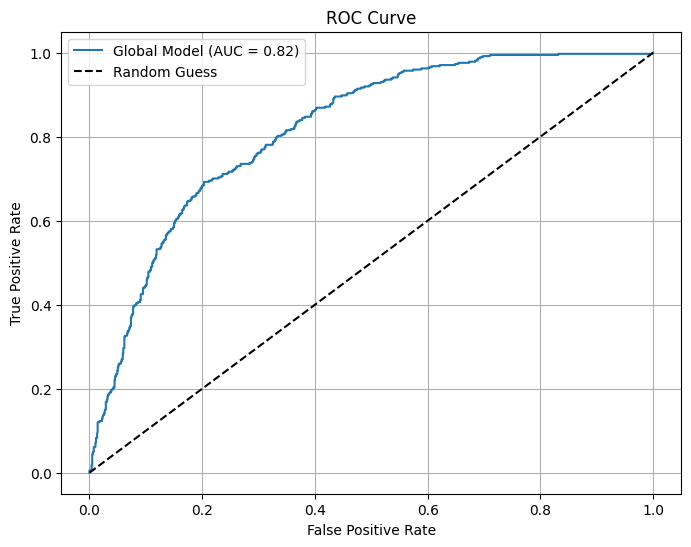

In [4]:
from io import BytesIO
import numpy as np
from sklearn.linear_model import LogisticRegression

# Load the global model parameters
global_model_path = "../../server/models/global_model.pkl"
global_parameters = load(global_model_path)  # This is a tuple
print("Global model parameters loaded successfully.")

# Extract tensors from the Parameters object in the tuple
parameters = global_parameters[0]  # Access the first item in the tuple

# Load coefficients and intercepts
coef_tensor = np.load(BytesIO(parameters.tensors[0]))  # Coefficients
intercept_tensor = np.load(BytesIO(parameters.tensors[1]))  # Intercepts

# Reconstruct the global model
global_model = LogisticRegression()
global_model.coef_ = coef_tensor
global_model.intercept_ = intercept_tensor

# Manually set classes_ based on the labels in y_train
global_model.classes_ = np.array([0, 1])  # Replace [0, 1] with actual unique labels in your dataset

print("Global model reconstructed successfully.")

# Evaluate the model
y_pred = global_model.predict(X_test)
y_pred_proba = global_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics using y_test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="Global Model (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()